In [1]:
import rom_inverse as ri
import torch
import matplotlib.pyplot as plt
# import sklearn.gaussian_process.kernels as kernels
from poisson_fem import PoissonFEM
import ROM
import numpy as np
import scipy as sp
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import os
import pyro.contrib.gp as gp
smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)       # can help with debugging
import time

In [2]:
lin_dim_fom = 32                      # Linear number of rom elements

kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(2.), lengthscale=torch.tensor([.3, .1]))
permeability_random_field = ri.DiscretizedRandomField(kernel=kernel, discretization_vector=
                            (torch.linspace(1/(2*lin_dim_fom), (lin_dim_fom - .5)/lin_dim_fom, lin_dim_fom),
                             torch.linspace(1/(2*lin_dim_fom), (lin_dim_fom - .5)/lin_dim_fom, lin_dim_fom)),
                                                     nugget=1e-3)

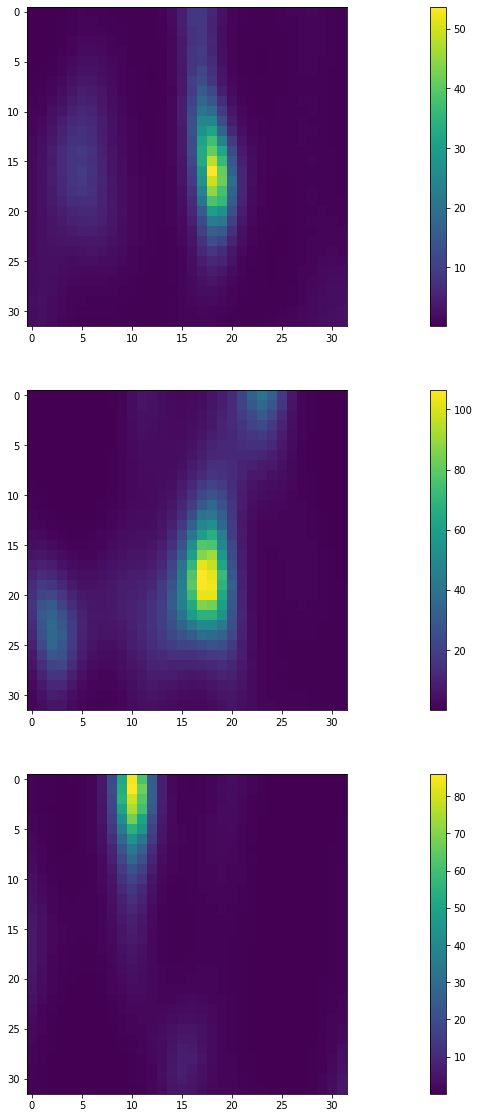

In [3]:
permeability_random_field.plot_realizations()

In [4]:
a = torch.tensor([1, 1, 0])               # Boundary condition function coefficients


# Define mesh and boundary conditions
mesh = PoissonFEM.RectangularMesh(torch.ones(lin_dim_fom)/lin_dim_fom)
# mesh.plot()

def origin(x):
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps and torch.abs(x[1]) < torch.finfo(torch.float32).eps

def ess_boundary_fun(x):
    return 0.0
mesh.set_essential_boundary(origin, ess_boundary_fun)

def domain_boundary(x):
    # unit square
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps or torch.abs(x[1]) < torch.finfo(torch.float32).eps or \
            torch.abs(x[0]) > 1.0 - torch.finfo(torch.float32).eps or torch.abs(x[1]) > 1.0 - torch.finfo(torch.float32).eps
mesh.set_natural_boundary(domain_boundary)

def flux(x):
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [5]:
#Specify right hand side and stiffness matrix
rhs = PoissonFEM.RightHandSide(mesh)
rhs.set_natural_rhs(mesh, flux)
K = PoissonFEM.StiffnessMatrix(mesh)
rhs.set_rhs_stencil(mesh, K)

In [6]:
# define fom
fom = ROM.ROM(mesh, K, rhs, lin_dim_fom**2)
# Change for non unit square domains!!
xx, yy = torch.meshgrid((torch.linspace(0, 1, lin_dim_fom), torch.linspace(0, 1, lin_dim_fom)))
X = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), 1)
fom.mesh.get_interpolation_matrix(X)

In [7]:
fom_autograd = fom.get_autograd_fun()

In [8]:
lmbda = permeability_random_field.sample_permeability(n_samples=3)

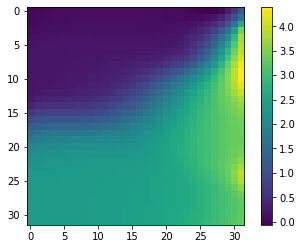

In [9]:
img = plt.imshow(fom_autograd(lmbda[0, :]).view(lin_dim_fom, lin_dim_fom))
plt.colorbar(img)

In [10]:
lmbda = torch.rand(lin_dim_fom**2, requires_grad=True)
x = fom_autograd(lmbda)
loss = torch.norm(x)
loss.backward()

In [11]:
def lossfun(x):
    return torch.norm(fom_autograd(x)) 

In [12]:
# from torch.autograd import gradcheck
# lmbda = torch.randn(lin_dim_fom**2, dtype=torch.double, requires_grad=True)
# test = gradcheck(lossfun, lmbda, eps=1e-3, atol=1e-4)
# print(test)

In [13]:
# define pyro model
beta = 1.0  # inverse temperature of observations
def uncertainty_propagation():
    lambda_f = permeability_random_field.sample()
    uf = fom_autograd(lambda_f)
    uf_observed = pyro.sample('uf_observed', dist.Normal(uf, torch.ones_like(uf)/beta))
    return uf_observed   

In [14]:
# nuts_kernel = NUTS(uncertainty_propagation)
# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100, num_chains=1)
# mcmc.run()
# mcmc.summary()

In [15]:
beta = 20
scale_tril = torch.cholesky(permeability_random_field.get_covariance_matrix())
mu_zero = torch.zeros(permeability_random_field.X.shape[0])
def joint_posterior():
    x = pyro.sample('x', dist.MultivariateNormal(mu_zero, scale_tril=scale_tril))
    lambdaf = torch.exp(x)
    uf = fom_autograd(lambdaf)
    uf_observed = pyro.sample('uf_observed', dist.Normal(uf, torch.ones_like(uf)/beta))
    return uf_observed

In [16]:
# nuts_kernel = NUTS(joint_posterior)
# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100, num_chains=1)
# mcmc.run()
# mcmc.summary()

In [17]:
print('x == ', x := permeability_random_field.sample_log_permeability())
print('uf_observed == ', uf_observed := fom_autograd(torch.exp(x)))

x ==  tensor([[ 0.1343,  0.0407,  0.2520,  ..., -1.0426, -0.4413,  0.2304]])
uf_observed ==  tensor([0.0000, 0.0214, 0.0331,  ..., 4.4657, 4.5210, 4.5607])


In [18]:
def conditioned_posterior(uf_observed):
    return pyro.condition(joint_posterior, data={"uf_observed": uf_observed})

In [19]:
nuts_kernel = NUTS(conditioned_posterior(uf_observed))
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100, num_chains=1)
mcmc.run()
mcmc.summary()

Sample: 100%|██████████| 300/300 [29:10,  5.84s/it, step size=2.56e-02, acc. prob=0.795]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]      0.08      0.19      0.05     -0.23      0.32    191.37      1.01
      x[1]      0.21      0.12      0.20      0.01      0.40    216.58      1.02
      x[2]      0.48      0.17      0.48      0.24      0.77    211.88      1.00
      x[3]      0.82      0.22      0.80      0.44      1.15    286.34      1.00
      x[4]      1.10      0.24      1.11      0.70      1.48    328.90      1.00
      x[5]      1.19      0.25      1.17      0.77      1.54    285.97      1.01
      x[6]      1.02      0.24      1.03      0.56      1.35    220.67      1.01
      x[7]      0.63      0.24      0.62      0.26      0.99    226.37      1.00
      x[8]      0.16      0.24      0.15     -0.19      0.58    214.14      1.00
      x[9]     -0.19      0.24     -0.17     -0.53      0.24    186.94      1.00
     x[10]     -0.28      0.22     -0.28     -0.65      0.02    205.38      1.00
     x[11]     -0.07      0

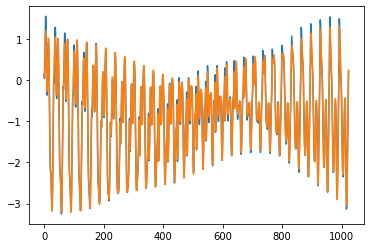

In [20]:
plt.plot(x[0])
plt.plot(torch.mean(mcmc.get_samples()['x'], 0))

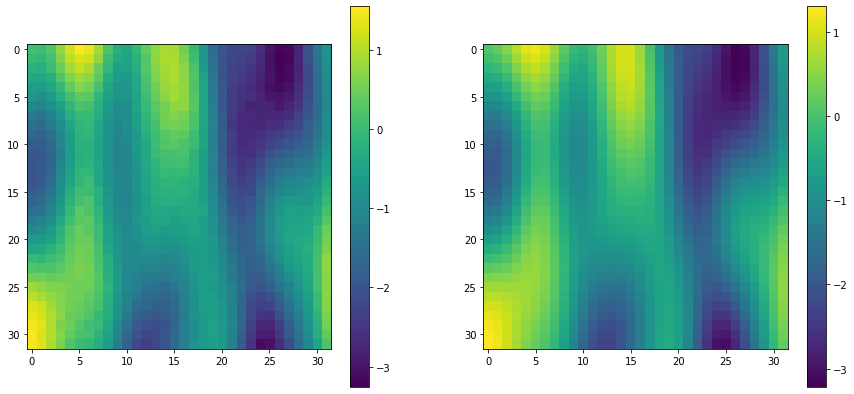

In [21]:
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 2, 1)
im0 = plt.imshow(x[0].view(lin_dim_fom, lin_dim_fom))
plt.colorbar(im0)
ax = plt.subplot(1, 2, 2)
im1 = plt.imshow(torch.mean(mcmc.get_samples()['x'], 0).view(lin_dim_fom, lin_dim_fom))
plt.colorbar(im1)

In [22]:
torch.cholesky(permeability_random_field.get_covariance_matrix())

tensor([[1.4146e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.3465e+00, 4.3357e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1630e+00, 7.8122e-01, 1.9518e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.1273e-20, 5.5972e-19, 1.7068e-17,  ..., 4.0152e-02, 0.0000e+00,
         0.0000e+00],
        [6.3225e-22, 3.4815e-20, 1.1780e-18,  ..., 1.4914e-02, 4.1357e-02,
         0.0000e+00],
        [3.2161e-23, 1.9629e-21, 7.3650e-20,  ..., 6.1198e-03, 1.5428e-02,
         4.7565e-02]], grad_fn=<CholeskyBackward>)

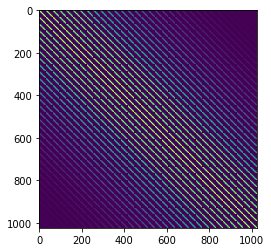

In [23]:
plt.imshow(permeability_random_field.get_covariance_matrix().detach().numpy())

In [24]:
torch.det(permeability_random_field.get_covariance_matrix())

tensor(0., grad_fn=<DetBackward>)

In [25]:
permeability_random_field.get_covariance_matrix()[permeability_random_field.get_covariance_matrix() < 1e-10] = .0

In [26]:
torch.det(permeability_random_field.get_covariance_matrix() + 1e-5*torch.eye(81))

RuntimeError: The size of tensor a (1024) must match the size of tensor b (81) at non-singleton dimension 1

In [ ]:
permeability_random_field.get_covariance_matrix().min()

In [ ]:
permeability_random_field.get_covariance_matrix().size()

In [ ]:
permeability_random_field.X.shape

In [ ]:
scale_tril = torch.cholesky(cov)

In [ ]:
scale_tril

In [35]:
torch.save(x, 'x_true.pt')

In [36]:
uf_observed

tensor([0.0000, 0.0214, 0.0331,  ..., 4.4657, 4.5210, 4.5607])

In [39]:
mcmc.get_samples()['x']

tensor([[ 0.1891,  0.1570,  0.4455,  ..., -0.9976, -0.5586,  0.0680],
        [ 0.2283,  0.1497,  0.3731,  ..., -0.7653, -0.4614, -0.4391],
        [ 0.0443, -0.0114,  0.4016,  ..., -0.5586, -0.1962, -0.1452],
        ...,
        [-0.1633,  0.0580,  0.4570,  ..., -0.7472, -0.3014,  0.0188],
        [-0.0849,  0.2865,  0.6440,  ..., -0.9331, -0.3194,  0.2914],
        [-0.1376,  0.0173,  0.5097,  ..., -0.8889, -0.1815,  0.4173]])